
# Conflicts and versions 

Conflicts are an essential part of any distributed system. 
Conflicts arise when there are two or more valid versions of the same message.

As we've seen from the previous notebooks, the network can be unreliable: there may be longer delays. But what about faults/conflicts from the clients/message producers? Moreover, a message might have multiple valid versions.  It could be that peers received two versions of the message, both being signed and valid. What version to choose? What to do when an order of the message is important? 



In [95]:
# Initialize the experiment:
import networkx as nx
import p2psimpy as p2p
import warnings
warnings.filterwarnings('ignore')

# Load the previous experiment configurations
exper = p2p.BaseSimulation.load_experiment(expr_dir='crash_gossip')

Locations, topology, peer_services, serv_impl = exper


## Client generating conflicting information

Let's assign first adversary nodes, we will assign randomly: 

In [96]:
import random
import string

from p2psimpy import BaseMessage, GossipMessage, MessageProducer, PullGossipService

from p2psimpy.consts import TEMPERED
from p2psimpy.config import Config, Func, Dist

class Transaction(BaseMessage):
    pass 

class ConflictMessageProducer(MessageProducer):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.balance = 100 
        
        
    def _generate_tx(self):        
        msg_phash = ''.join(random.choices(string.ascii_uppercase, k=20))
        diff = random.randint(1, 9)        
        data = {'hash': msg_phash, 'balance': self.balance-diff, 'diff': diff}
        tx = Transaction(self.peer, data)
        
        msg_id = '_'.join((str(self.peer.peer_id), str(self.counter)))
        msg_ttl = self.init_ttl
        return GossipMessage(self.peer, msg_id, tx, msg_ttl, 
            pre_task=self.pre_task, post_task=self.post_task)
    
    def produce_transaction(self):
        # generate new transaction
        msg = self._generate_tx()
        if self.balance - msg.data.data['diff'] < 0:
            return
        
        cons = list(self.peer.connections.keys())
        m_ix = len(cons) // 2
        for p in cons[:m_ix]:
            self.peer.send(p, msg)
            
        # Generate conflicting message as if previous transaction hasn't happened  
        msg = self._generate_tx()
        for p in cons[m_ix:]:
            self.peer.send(p, msg)
        
        self.peer.store('msg_time', str(self.peer.peer_id) +'_' + str(self.counter), self.peer.env.now)
        self.peer.store('msg_data', str(self.peer.peer_id) + '_' + str(self.counter), msg)
        self.balance -= msg.data.data['diff']
        self.counter+=1

def validate_task(msg, peer):
    # time it takes to verify the signature
    crypto_verify = Dist('norm', (1, 0.2)) 
    # time to verify the message data
    msg_verify = Dist("lognorm", (0.49512563, 4.892564, 0.0425785)) 
    
    yield peer.env.timeout(crypto_verify.get() + msg_verify.get())
    if isinstance(msg, Transaction):        
        tx = msg.data
        if tx == TEMPERED or tx['balance'] < 0:
            # You can decide what to do in this case.
            return False
    return True


class MsgConfig(Config):
    pre_task = Func(validate_task)
    
peer_services['client'].service_map['MessageProducer'] = MsgConfig
serv_impl['MessageProducer'] = ConflictMessageProducer
serv_impl['RangedPullGossipService'] = PullGossipService

## Run simulation 

Let's see how adversarial agents together with crashing nodes affect the message dissemination. 

In [97]:
# Init Graph
sim = p2p.BaseSimulation(Locations, topology, peer_services, serv_impl)
sim.run(5_200)

## Message analysis

Let's see how this fraction of adverserial nodes affected the network. 


In [98]:
import pandas as pd

def message_data(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for msg_id, tx in store.items():
        client_id, msg_num = msg_id.split('_')
        client_tx = sim.peers[int(client_id)].storage[storage_name].txs[msg_id]
        yield (int(msg_num), tx.data == client_tx.data)
        
def get_gossip_table(sim, storage_name, func):
    return pd.DataFrame({k: dict(func(sim, k, storage_name)) 
                         for k in set(sim.types_peers['peer'])}).sort_index()

    
df = get_gossip_table(sim, 'msg_data', message_data)
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,True,True,False,True
2,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,True,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,True,True,False,False
4,True,False,True,False,False,False,False,False,True,False,...,False,False,True,False,True,False,True,True,True,False
5,True,False,True,False,False,False,False,False,False,False,...,False,False,True,False,True,False,True,True,True,False
6,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,True,False,True,True,True,False,False,True,True,False,...,False,False,True,True,True,False,True,True,True,True
8,True,False,True,True,True,False,False,True,True,False,...,False,False,True,True,True,False,True,True,True,True
9,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,False,True,True,True,True
10,True,False,True,False,False,True,True,True,False,True,...,True,True,True,False,True,False,False,True,True,True


In [99]:
df[df==False].count()

1      2
2     19
3     11
4     15
5     11
6     13
7     16
8     12
9      9
10    15
11    16
12    14
13    14
14    12
15    12
16    18
17    10
18     8
19    17
20     1
21    19
22     5
23     1
24     9
25    12
dtype: int64

In [100]:
sim.peers[1].storage['msg_data'].txs

{'26_1': GossipMessage:Transaction:{'hash': 'HBRAHKAQAVQBRPTBIMFV', 'balance': 98, 'diff': 2},
 '26_2': GossipMessage:Transaction:{'hash': 'ZYSEKWQCXWPCMHJQYMUQ', 'balance': 93, 'diff': 5},
 '26_3': GossipMessage:Transaction:{'hash': 'YHWIUTEVTACZXOYURMNB', 'balance': 90, 'diff': 3},
 '26_4': GossipMessage:Transaction:{'hash': 'DAUSGIHHYAXZSBKJLXKS', 'balance': 86, 'diff': 4},
 '26_5': GossipMessage:Transaction:{'hash': 'XDJJGXGFWMRKHPYUAFVX', 'balance': 80, 'diff': 6},
 '26_6': GossipMessage:Transaction:{'hash': 'BPDESOPXMWGKEQSXHPVT', 'balance': 77, 'diff': 3},
 '26_7': GossipMessage:Transaction:{'hash': 'CFXNYPKNYUACQBHVZVUF', 'balance': 71, 'diff': 6},
 '26_10': GossipMessage:Transaction:{'hash': 'VLORPLBUMVZLXZDUUBBR', 'balance': 53, 'diff': 8},
 '26_8': GossipMessage:Transaction:{'hash': 'BDORZKUKVSJXSNLQLVQZ', 'balance': 68, 'diff': 3},
 '26_9': GossipMessage:Transaction:{'hash': 'ANCGNJDMEIFJCLZSKQCV', 'balance': 61, 'diff': 7},
 '26_11': GossipMessage:Transaction:{'hash': 'GCK

In [101]:
sim.peers[3].storage['msg_data'].txs

{'26_2': GossipMessage:Transaction:{'hash': 'YUWJDKRJZPLWQPXIXFYD', 'balance': 94, 'diff': 4},
 '26_1': GossipMessage:Transaction:{'hash': 'FFQAIRQHLVWVRGVZVGJX', 'balance': 97, 'diff': 3},
 '26_3': GossipMessage:Transaction:{'hash': 'GRUWDWTUWEUKMMHFDXNJ', 'balance': 91, 'diff': 2},
 '26_5': GossipMessage:Transaction:{'hash': 'XDJJGXGFWMRKHPYUAFVX', 'balance': 80, 'diff': 6},
 '26_4': GossipMessage:Transaction:{'hash': 'DAUSGIHHYAXZSBKJLXKS', 'balance': 86, 'diff': 4},
 '26_6': GossipMessage:Transaction:{'hash': 'ZCJJWLEOLUIOALTIVRLL', 'balance': 71, 'diff': 9},
 '26_7': GossipMessage:Transaction:{'hash': 'CFXNYPKNYUACQBHVZVUF', 'balance': 71, 'diff': 6},
 '26_8': GossipMessage:Transaction:{'hash': 'BDORZKUKVSJXSNLQLVQZ', 'balance': 68, 'diff': 3},
 '26_10': GossipMessage:Transaction:{'hash': 'VLORPLBUMVZLXZDUUBBR', 'balance': 53, 'diff': 8},
 '26_9': GossipMessage:Transaction:{'hash': 'ANCGNJDMEIFJCLZSKQCV', 'balance': 61, 'diff': 7},
 '26_11': GossipMessage:Transaction:{'hash': 'RQQ

Peers see different versions of the same message!
This is an issue as it might violate integrity guarantees. For example, peers might have a different view on the client's balance. 

How to fix this? 
- One way to solve this is to use a (consensus algorithm)[https://en.wikipedia.org/wiki/Consensus_(computer_science)]


# Consensus algorithm


The consensus is a process that allows achieving a consistent view on a value (agreement). 
Some of the peers may fail or be unreliable, so consensus protocols must be fault-tolerant or resilient. The peers must communicate with one another and agree on a single value.

The consensus problem is fundamental in all distributed systems. One approach to generating consensus is for all processes (agents) to agree on a majority value. In this context, a majority requires at least one more than half of the available votes (where each process is given a vote). However, one or more faulty processes may skew the resultant outcome such that consensus may not be reached or reached incorrectly.



#  Exercise 

In this notebook we ask to implement a consensus service and show that all honest peers accept the same value.  
You can assume that an elected leader is never faulty. 
Here are some poissible algorithms you can consider: 
- **Majority Voting**. Fully connected network. Send votes to all nodes. Choose the value based on majority/super-majority. How many rounds/phases do you need?  
- **Majority Voting with Neighbours**. Connected network. Send votes to all neighbors. Choose the value based on majority/super-majority of your neighbors. How many rounds/phases you need for full convergence? 
- **Consensus through a lottery**. Send transactions through gossip. Everybody runs some lottery mechanism: that both takes time and chooses one or several nodes. This(these) nodes decide which version of the transaction to pick and send through gossip a decided version of transactions (block). How many rounds of lottery you need for convergence? 

**You can choose any of the above algorithm or propose your own**


# Solution
We choose to implement majority voting with a fully connected network. We connect all the peers to each other and we randomly select a leader, which will be responsible for running the elections. The logic behind our solution is that at any moment there are two kinds of messages going around in the network, new messages which may have conflicting values, as well as messages that are the result of an election and should have a unique value. 
To mirror that fact, we create two pull based gossip services, one for the unconfirmed messages and one for the confirmed election results, running in parallel. We chose that implementation since it seemed that the major issue with the election process is that some nodes missed the result due to random downtime, and they remained with incorrect or no value for the missed message. With the additional pulled service for the confirmed voted messages, those nodes could request the election results from their neighbors.
We have made some assumptions for simplicity, such as that the voted results will be cryptographically signed by the trusted leader so the malicious nodes cannot propagate false messages. The role of the malicious nodes in the election is to achieve consensus on an incorrect message. There are potentially other attacks such as the ones presented in the previous notebook, e.g. as propagating a 'confirmed', signed version of a message but with outdated data for a specific message id, but we focus on the election process.

The election process takes three phases. When the election leader discovers a new unconfirmed message circulating, it starts an election for it. It broadcasts to all nodes the request to vote with the value they have for that message id.
During the second phase, the nodes send their votes if they have seen the message, with the value they have seen.
The election ends after an amount of time and in the third phase the leader counts the votes, decides on the final value of the specific message and broadcasts it to all nodes, to be added in the 'confirmed' message flow.

In [102]:
# Initialize the experiment:
import networkx as nx
import p2psimpy as p2p
import warnings
warnings.filterwarnings('ignore')
from p2psimpy.messages import *
from p2psimpy.config import *
from p2psimpy.services.connection_manager import BaseConnectionManager
from p2psimpy import BaseRunner,BaseHandler
from p2psimpy import BaseMessage, GossipMessage, MessageProducer, PullGossipService

# Load the previous experiment configurations
exper = p2p.BaseSimulation.load_experiment(expr_dir='crash_gossip')

Locations, topology, peer_services, serv_impl = exper

In [103]:
def visualize_graph(G, ax=None):
    master_nodes = [n for (n,ty) in \
    nx.get_node_attributes(G,'type').items() if ty == 'peer' or ty == 'peer_leader']
    client_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'client']
    malicious_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'malicious']

    pos = nx.kamada_kawai_layout(G)
    
    nx.draw_networkx_nodes(G, pos, nodelist=malicious_nodes, \
        node_color='yellow', node_shape='o', node_size=500, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=master_nodes, \
        node_color='blue', node_shape='o', node_size=500, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=client_nodes,  \
        node_color='green', node_shape='^', node_size=500, label=1, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=[peer_leader],  \
    node_color='magenta', node_shape='o', node_size=500, alpha=0.5, label=1, ax=ax)
    nx.draw_networkx_labels(G, pos, labels={k:k for k in master_nodes}, font_color='w', ax=ax)
    nx.draw_networkx_labels(G, pos, labels={k:k for k in malicious_nodes}, font_color='b', ax=ax)
    
    nx.draw_networkx_edges(G, pos, edgelist=G.subgraph(set(master_nodes)|set(malicious_nodes)).edges(), width=1.5, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(nbunch=client_nodes),  style='dotted', ax=ax)

    

In [104]:
class VoteRequestMessage(BaseMessage):
    pass
class VoteMessage(BaseMessage):
    pass 
class VoteResultMessage(BaseMessage):
    pass 
class VotedSyncPing(BaseMessage):
    pass

class VotedSyncPong(BaseMessage):
    pass

class VotedMsgRequest(BaseMessage):
    pass

class VotedMsgResponse(BaseMessage):
    pass 

In [105]:
## Load message responder to extend PullGossipService class
class VoteMessageResponder(BaseHandler):

    def _form_message_response(self, msg):
        response = {}
        for k in msg.data:
            response[k] = self.peer.get_storage('voted_msg_data').get(k)
        return response

    def handle_message(self, msg):
        self.peer.send(msg.sender, VotedMsgResponse(
            self.peer, self._form_message_response(msg)))

    @property
    def messages(self):
        return VotedMsgRequest,

In [106]:
from p2psimpy.storage.simple import Storage
from p2psimpy.utils import Cache
class PullGossipVotedService(VoteMessageResponder, BaseRunner):

    def __init__(self, peer,
                 exclude_types: set = None, exclude_peers: set = None,
                 fanout=5, round_time=500,
                 init_timeout=Dist('norm', (200, 100))):
        super().__init__(peer)

        self.fanout = fanout
        if exclude_peers is None:
            self.exclude_peers = set()
        else:
            self.exclude_peers = exclude_peers
        self.exclude_types = exclude_types

        self.sync_time = round_time
        self._init_stores()
        self.strg = self.peer.get_storage('voted_msg_data')

        self.ini_time = abs(Cache(init_timeout).fetch())

    def _init_stores(self):
        self.peer.add_storage('voted_msg_time', Storage())
        self.peer.add_storage('voted_msg_data', Storage())

    def _get_sync_indexes(self):
        """ Will return all known indexes 
        """
        return self.strg.get_known_tx_ids()
    
    def update_unconfirmed_values(self):
        known = self.strg.get_known_tx_ids()
        unconfirmed = self.peer.storage['msg_data'].txs.keys() 
        for msg_id in set(known).intersection(unconfirmed):
            self.peer.storage['msg_data'].txs[msg_id] = self.peer.storage['voted_msg_data'].txs[msg_id]
            
            

    def run(self):
        yield self.env.timeout(self.ini_time)
        while True:
            # choose random peers and perioducally synchronize the data - by filling out the missing links
            yield self.env.timeout(self.sync_time)
            self.update_unconfirmed_values()
            self.peer.gossip(VotedSyncPing(self.peer, self._get_sync_indexes()), self.fanout,
                             except_peers=self.exclude_peers, except_type=self.exclude_types)

    def _self_missing(self, msg):
        known = self.strg.get_known_tx_ids()

        me_missing = set(msg.data) - set(known)
        if len(me_missing) > 0:
            # Request missing messages
            self.peer.send(msg.sender, VotedMsgRequest(self.peer, me_missing))

    def _peer_missing(self, msg):
        known = self.strg.get_known_tx_ids()
        peer_missing = set(known) - set(msg.data)
        if len(peer_missing) > 0:
            self.peer.send(msg.sender, VotedSyncPong(self.peer, peer_missing))

    def _store_message(self, msg, msg_id=None):
        if not msg_id:
            msg_id = msg.id

        self.peer.store('voted_msg_time', msg_id, self.peer.env.now)
        self.peer.store('voted_msg_data', msg_id, msg)

    def handle_message(self, msg):
        if type(msg) == VotedSyncPing:
            # Send sync pong if there more known messages
            self._peer_missing(msg)
            self._self_missing(msg)
        elif type(msg) == VotedSyncPong:
            self._self_missing(msg)
        elif type(msg) == VotedMsgRequest:
            # Answer with message response
            VoteMessageResponder.handle_message(self, msg)
        elif type(msg) == VotedMsgResponse:
            # Apply to the local storage
            for k, v in msg.data.items():
                self._store_message(v, k)
        elif type(msg) == VoteRequestMessage:
            self.handle_vote_request_message(msg)
        elif type(msg) == VoteResultMessage:
            self.handle_vote_result_message(msg)
            
    def handle_vote_result_message(self,msg):
        self.peer.storage['voted_msg_time'].txs[msg.data['id']] = self.peer.env.now
        self.peer.storage['voted_msg_time'].times_seen[msg.data['id']] = 1
        self.peer.storage['voted_msg_data'].txs[msg.data['id']] = msg.data['data']
        self.peer.storage['voted_msg_data'].times_seen[msg.data['id']] = 1
            
    def handle_vote_request_message(self,msg):
        known = self.peer.storage['msg_data'].txs.keys()
        msg_id = msg.data['id']
        if msg_id in known:
            self.peer.send(msg.sender, VoteMessage(self.peer, data={'id':msg_id, 'data':self.peer.storage['msg_data'].txs[msg_id]}))

    @property
    def messages(self):
        return VotedSyncPing, VotedSyncPong, VotedMsgRequest, VotedMsgResponse, VoteRequestMessage, VoteResultMessage

In [107]:
## Load message responder to extend PullGossipService class
class MessageResponder(BaseHandler):

    def _form_message_response(self, msg):
        response = {}
        for k in msg.data:
            response[k] = self.peer.get_storage('msg_data').get(k)
        return response

    def handle_message(self, msg):
        self.peer.send(msg.sender, MsgResponse(
            self.peer, self._form_message_response(msg)))

    @property
    def messages(self):
        return MsgRequest,

In [108]:
class PullGossipServiceWithVoting(PullGossipService):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def handle_message(self, msg):
        if type(msg) == GossipMessage:
            if msg.id not in self.peer.storage['voted_msg_data'].txs.keys():
                self._store_message(msg)
        elif type(msg) == SyncPing:
            # Send sync pong if there more known messages
            self._peer_missing(msg)
            self._self_missing(msg)
        elif type(msg) == SyncPong:
            self._self_missing(msg)
        elif type(msg) == MsgRequest:
            # Answer with message response
            MessageResponder.handle_message(self, msg)
        elif type(msg) == MsgResponse:
            # Apply to the local storage
            confirmed_ids = self.peer.storage['voted_msg_data'].txs.keys()
            for k, v in msg.data.items():
                if k not in confirmed_ids:
                    self._store_message(v, k)

        

Since the malicious nodes cannot tamper data anymore due to cryptographic signature, we will assume that FALSE_TRANSACTION stands for valid, older data or possibly valid data for a different message id, e.g. indicating a different balance for a node. In any case, the malicious nodes will try to affect the voting process and achieve majority for the wrong message.

In [109]:
import random
msg_phash = 'INVALIDTRANSACTION00'
diff = random.randint(1, 9)        
false_data = {'hash': msg_phash, 'balance': 100-diff, 'diff': diff}
FALSE_TRANSACTION = GossipMessage(None,'26_1',Transaction(None, false_data),1)

class MaliciousPullGossipServiceWithVoting(PullGossipVotedService):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
            
    def handle_vote_request_message(self,msg):
        known = self.strg.get_known_tx_ids()
        msg_id = msg.data['id']
        self.peer.send(msg.sender, VoteMessage(self.peer, data={'id':msg_id, 'data':FALSE_TRANSACTION}))

In [110]:
from collections import defaultdict

class VoteLeaderService(BaseRunner, BaseHandler):
    
    
    def __init__(self, peer, run_interval=100, init_timeout=1000, voting_duration=500):
        
        super().__init__(peer)
        self.run_interval = run_interval
        self.init_timeout = init_timeout
        self.voting_duration = voting_duration
        self.running_vote_ids = set() 
        self.have_voted = {}
        self.running_votes = {}
        self.election_start = {}
        
    
    
    def handle_message(self,msg):
        if isinstance(msg, VoteMessage):
            self.handle_vote_message(msg)
        
    def handle_vote_message(self,msg):
        msg_id = msg.data['id']
        msg_data = msg.data['data']
        if msg_id in self.running_vote_ids and msg.sender not in self.have_voted[msg_id]:
            self.running_votes[msg_id][msg_data] += 1
            self.have_voted[msg_id].add(msg.sender)
            
            
    def conclude_voting(self, msg_id):
        self.running_vote_ids.remove(msg_id)
        data = sorted(self.running_votes[msg_id].keys(),reverse=True,key=lambda x:self.running_votes[msg_id][x])[0]
        self.peer.storage['voted_msg_time'].txs[msg_id] = self.peer.env.now
        self.peer.storage['voted_msg_time'].times_seen[msg_id] = 1
        self.peer.storage['voted_msg_data'].txs[msg_id] = data
        self.peer.storage['voted_msg_data'].times_seen[msg_id] = 1
        self.peer.broadcast(VoteResultMessage(self.peer,data={'id':msg_id,'data':data}),except_type={'client'})
    
    def run(self):
        # Wait the initial timeout
        yield self.env.timeout(self.init_timeout)
        while True:
            for msg_id in self.running_vote_ids.copy():
                if (self.peer.env.now - self.election_start[msg_id]) > self.voting_duration:
                    self.conclude_voting(msg_id)
            candidates = set(self.peer.storage['msg_data'].txs.keys()) - set(self.peer.storage['voted_msg_data'].txs.keys()) - self.running_vote_ids
            for msg_id in candidates:
                self.election_start[msg_id] = self.peer.env.now
                self.running_votes[msg_id] = defaultdict(int)
                self.have_voted[msg_id] = set()
                self.running_vote_ids.add(msg_id)
                self.peer.broadcast(VoteRequestMessage(self.peer,data={'id':msg_id}), except_type={'client'})
            yield self.env.timeout(self.run_interval)
        
    @property
    def messages(self):
        return VoteMessage,

In [111]:
# Change peer to a malicious 
from itertools import groupby
from random import sample, choice

frac_malicious_nodes = 0.3 # 30 % of malicious nodes


def assign_malicious_peers(topology, mal_frac):
    type_dict = nx.get_node_attributes(topology, 'type')
    inv_type_dict = {k: {j for j, _ in list(v)}
                                for k, v in groupby(type_dict.items(), lambda x: x[1])}
    mal_nodes = sample(list(inv_type_dict['peer']), 
                       int(frac_malicious_nodes * len(inv_type_dict['peer'])))
    for b in mal_nodes:
        type_dict[b] = 'malicious'
        
    nx.set_node_attributes(topology, type_dict, 'type')

In [112]:
def fully_connect_peers(topology):
    type_dict = nx.get_node_attributes(topology, 'type')
    inv_type_dict = {k: {j for j, _ in list(v)}
                                for k, v in groupby(type_dict.items(), lambda x: x[1])}
    for p1 in inv_type_dict['peer']:
        for p2 in inv_type_dict['peer'] - set([p1]):
            topology.add_edge(p1,p2)

In [113]:
def select_leader(topology):
    type_dict = nx.get_node_attributes(topology, 'type')
    inv_type_dict = {k: {j for j, _ in list(v)}
                                for k, v in groupby(sorted(type_dict.items(), key=lambda x:x[1]), lambda x: x[1])}

    leader = choice(list(inv_type_dict['peer']))
    type_dict[leader] = 'peer_leader'
    nx.set_node_attributes(topology, type_dict, 'type')
    return leader

In [114]:
fully_connect_peers(topology)
assign_malicious_peers(topology, frac_malicious_nodes)
peer_leader = select_leader(topology)

In [115]:
peer_services['client'].service_map['MessageProducer'] = MsgConfig
serv_impl['MessageProducer'] = ConflictMessageProducer
serv_impl['RangedPullGossipService'] = PullGossipServiceWithVoting
serv_impl['PullGossipVotedService'] = PullGossipVotedService
gossip_config = peer_services['peer'].service_map['RangedPullGossipService']
downtime_config = peer_services['peer'].service_map['RandomDowntime']
peer_services['peer'].service_map['PullGossipVotedService'] = gossip_config

peer_services['malicious'] = PeerType(peer_services['peer'].config,
                                      {p2p.BaseConnectionManager:None,
                                       MaliciousPullGossipServiceWithVoting: gossip_config,
                                      serv_impl['RandomDowntime']:downtime_config,
                                       PullGossipServiceWithVoting: gossip_config,
                                      PullGossipVotedService: gossip_config}
                                     )

peer_services['peer_leader'] = PeerType(peer_services['peer'].config, 
                                        {BaseConnectionManager: None,
                                                VoteLeaderService: None,
                                         PullGossipServiceWithVoting: gossip_config,
                                         PullGossipVotedService:gossip_config
                                        })

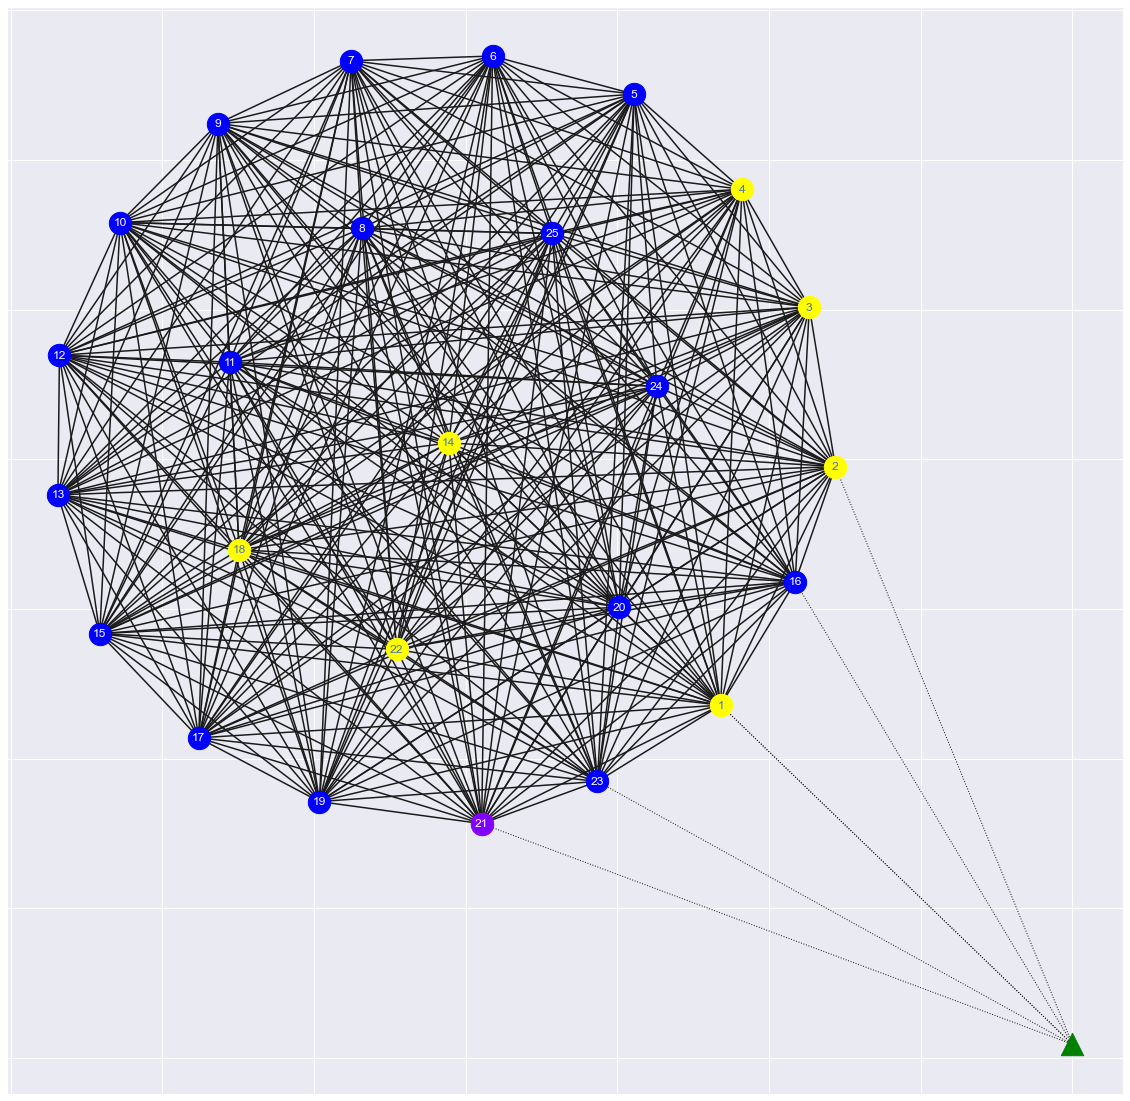

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(20,20))
visualize_graph(topology)

In [117]:
sim = p2p.BaseSimulation(Locations, topology, peer_services, serv_impl,enable_logger=True,logger_dir='voting')
sim.run(5_200)

In [118]:
import pandas as pd

def message_data(sim, peer_id, storage_name_peer):
    store = sim.peers[peer_id].storage[storage_name_peer].txs
    for msg_id, tx in store.items():
        _, msg_num = msg_id.split('_')
        yield (int(msg_num), tx.data)
        
def get_gossip_table(sim, storage_name_peer, func):
    return pd.DataFrame({k: dict(func(sim, k, storage_name_peer)) 
                         for k in set(sim.types_peers['peer'])}).sort_index()

    
df = get_gossip_table(sim, 'voted_msg_data', message_data)

In [119]:
df.apply(lambda x: len(set(x))==1,axis=1)

1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16    False
17    False
18    False
dtype: bool

In [120]:
df.apply(set,axis=1)

1     {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
2     {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
3     {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
4     {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
5     {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
6     {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
7     {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
8     {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
9     {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
10    {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
11    {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
12    {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
13    {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
14    {Transaction:{'hash': 'SOBNGOXTGZDDABUOHAPU', ...
15    {Transaction:{'hash': 'INVALIDTRANSACTION00', ...
16    {nan, Transaction:{'hash': 'INVALIDTRANSACTION...
17    {nan, Transaction:{'hash': 'INVALIDTRANSACTION...
18    {nan, Transaction:{'hash': 'INVALIDTRANSAC

In [121]:
df.sum(axis=1)

1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
dtype: float64

In [122]:
df.isna().sum(axis=1)

1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    2
18    1
dtype: int64

We see that all honest peers have agreed on a specific value. There are some NaN values for the latest messages, which means that the confirmed version hasn't fully propagated yet. We see a large amount of messages with the incorrect value of the malicious nodes, and that is because the malicious nodes always vote, regardless of whether they have seen the message requested or not. This, combined with the fact that some honest nodes have not seen the message id requested and so they skip the vote, as well as the fact that there always exist 2 conflictiing versions of the same message in circulation, makes it quite easy for the malicious nodes to achieve majority in some cases, even being 30% of the total nodes. However, this attack may not be useful in the real-world, since a specific message would also depend on the hash of the previous and the malicious nodes could not replicate that.